# ResNet for CIFAR-10 Image Classification

### ResNet50 Architecture:

![image.png](attachment:image.png)


### An example of self-built ResNet:

https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb

### Benchmarks:

**Environment:**
- Google cloud
- CPU: Intel Haswell 8 vCPUs
- Memory: 50G
- GPU: 1 x NVIDIA Tesla V100
- Disk: SSD 100G
- Tensorflow v2.0.0


**Structure of the self-built ResNet:**
- **ResNet22**: Contains 17 Conv2d layers, and 4 FC layers;
- **ResNet34**: Contains 29 Conv2d layers, and 4 FC layers;
- There're two kinds of Conv2d blocks: **convolutional_block** and **identity_block**. Each block contains two Conv2d layers;
- **convolutional_block** increases the number of feature maps, whereas **identity_block** doesn't. 
- There's an option to add dropout (actually by feeding augmented images, we don't need dropout).
- As oppose to the original ResNet paper where an AveragePooling was used, here I only use MaxPooling.

**Results:**
- With image augmentation, epochs = 150, batch_size = 128:

|                      | with dropout               | without dropout              |
|----------------------|:--------------------------:|:----------------------------:|
|<img width=200/>      |<img width=200/>            |<img width=200/>              |
|ResNet22, shortcut on |                            |  Loss = 0.28, acc = 92.7%    |
|ResNet22, shortcut off| Loss = 0.24, acc = 92.4%   |  Loss = 0.26, acc = 92.7%    |
|ResNet34, shortcut on |                            |  Loss = 0.25, acc = 93.4%    |
|ResNet34, shortcut off|                            |  Loss = 0.24, acc = 92.7%    |



- No image augmentation, epochs = 150, batch_size = 128:

|                      | with dropout               | without dropout              |
|----------------------|:--------------------------:|:----------------------------:|
|<img width=200/>      |<img width=200/>            |<img width=200/>              |
|ResNet22, shortcut on |                            |  Loss = 0.95, acc = 86.2%    |
|ResNet22, shortcut off|  Loss = 0.60, acc = 89.5%  |  Loss = 0.95, acc = 86.0%    |
|ResNet34, shortcut on |                            |  Loss = 0.84, acc = 86.4%    |
|ResNet34, shortcut off|  Loss = 0.57, acc = 88.3%  |  Loss = 0.85, acc = 85.9%    |


### Findings
- Shortcut did help when the NN get deeper (from ResNet22 to ResNet34).
- With image augmentation, dropout is not necessary.
- Without image augmentation, dropout is effective to mitigate overfitting.
- However, how to balance the dropout rate on the main path and that on the short cut path is tricky.

# Check hardware

In [1]:
import multiprocessing
print(multiprocessing.cpu_count())
!nvidia-smi

8
Thu Dec  5 02:23:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU

In [13]:
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf

# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.models import Model, Sequential 
# from tensorflow.keras.layers import Input, Conv2D, Dense
# from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, ZeroPadding2D
# from tensorflow.keras.layers import Add, Activation, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import models
# from tensorflow.keras import backend as K

from keras.datasets import cifar10
from keras.models import Model, Sequential 
from keras.layers import Input, Conv2D, Dense
from keras.layers import MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Add, Activation, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import models
from keras import backend as K

%matplotlib inline
print(tf.__version__)

2.0.0


Using TensorFlow backend.


In [3]:
def plot_learning_curve(modelHistory, model_name):
    history = pd.DataFrame()
    history["Train Loss"] = modelHistory.history['loss']
    history["Validation Loss"] = modelHistory.history['val_loss']
    if 'acc' in modelHistory.history.keys():
        history["Train Accuracy"] = modelHistory.history['acc']
    else:
        history["Train Accuracy"] = modelHistory.history['accuracy']
    if 'val_acc' in modelHistory.history.keys():
        history["Validation Accuracy"] = modelHistory.history['val_acc']
    else:
        history["Validation Accuracy"] = modelHistory.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=1, ncols=2 ,figsize=(12, 6))
    axarr[0].set_xlabel('Epoch')
    axarr[0].set_title("Loss in Train and Validation Datasets")
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[0].grid()
    axarr[1].set_xlabel('Epoch')
    axarr[1].set_title("Accuracy in Train and Validation Datasets")
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1]) 
    axarr[1].grid()
    plt.suptitle("Model {} Loss and Accuracy".format(model_name))
    plt.show()


# Data load

In [4]:
# Either use Kaggle dataset, or use Keras dataset directly.
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 

# print(os.listdir("../input"))
# !tar -zxvf ../input/cifar10-python/cifar-10-python.tar.gz

num_classes = 10
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Data visualization

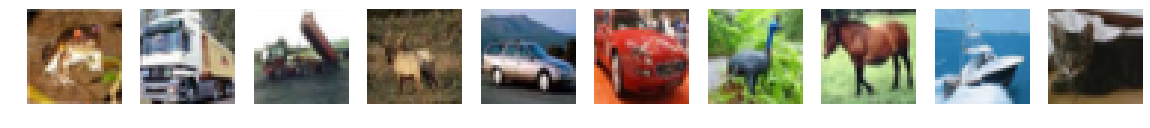

In [5]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

In [6]:
# Convert y_train and y_test into one-hot labels
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

# Rescale X_train and X_test
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test  = X_test/255

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


# Train model

In [7]:
def identity_block(X, f, filters, shortcut_on, dropout_on, dropout_rates, stage, block):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the Conv kernel for the main path
    filters -- python list of integers, defining the number of filters in the Conv layers of the main path
    shortcut_on -- boolean, with shortcut or not
    dropout_on -- boolean, with dropout layers or not
    dropout_rates -- python list of float, defining the dropout_rate after each Conv layer
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network    
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    
    Note:
    the input channel number and the output channel number (filters[2]) must be the same.
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters

    # Retrieve dropout_rates
    D1, D2 = dropout_rates
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(3,3), strides=(1,1), padding='same', name=conv_name_base+'2a')(X)
    X = BatchNormalization(name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    if dropout_on:
      X = Dropout(D1)(X)
    
    # Second component of main path 
    X = Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(name=bn_name_base+'2b')(X)
    ##### MAIN PATH END #####

    ##### SHORTCUT PATH #### 
    if dropout_on:
        X_shortcut = Dropout(D2)(X_shortcut)  # Shortcut with dropout performs better

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    if shortcut_on:
        X = Add()([X, X_shortcut])    

    X = Activation('relu')(X)

    return X

In [8]:
def convolutional_block(X, f, filters, stride, shortcut_on, dropout_on, dropout_rates, stage, block):
    """
    Implementation of the convolutional_block block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the Conv kernel for the main path
    filters -- python list of integers, defining the number of filters in the Conv layers of the main path
    stride -- Integer, specifying the stride to be used
    shortcut_on -- boolean, with shortcut or not
    dropout_on -- boolean, with dropout layers or not
    dropout_rates -- python list of float, defining the dropout_rate after each Conv layer
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters

    # Retrieve dropout_rates
    D1, D2 = dropout_rates
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(3,3), strides=(stride,stride), padding='same', name=conv_name_base+'2a')(X)
    X = BatchNormalization(name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    if dropout_on:
        X = Dropout(D1)(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(name=bn_name_base+'2b')(X)
    ##### MAIN PATH END #####

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F2, kernel_size=(1,1), strides=(stride,stride), padding='valid', name=conv_name_base+'1')(X_shortcut)
    if dropout_on:
        X_shortcut = Dropout(D2)(X_shortcut)  # Shortcut with dropout performs better
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    if shortcut_on:
        X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [9]:
def ResNet(shortcut_on, dropout_on, dropout_rates, input_shape=(32, 32, 3), classes=10):
    """
    Arguments:

    shortcut_on -- boolean, with shortcut or not
    dropout_on -- boolean, with dropout layers or not
    dropout_rates -- python list of float, defining the dropout_rate after each Conv layer
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)  # output: 34 x 34 x 3

    # Stage 1
    X = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', name='conv0')(X)  # output: 32 x 32 x 32
    X = BatchNormalization(name='bn_conv0')(X)
    X = identity_block(X, 3, [32, 32], shortcut_on, dropout_on, dropout_rates, stage=1, block='a')    # output: 32 x 32 x 32
    X = identity_block(X, 3, [32, 32], shortcut_on, dropout_on, dropout_rates, stage=1, block='b')    # output: 32 x 32 x 32
    X = identity_block(X, 3, [32, 32], shortcut_on, dropout_on, dropout_rates, stage=1, block='c')    # output: 32 x 32 x 32
    X = identity_block(X, 3, [32, 32], shortcut_on, dropout_on, dropout_rates, stage=1, block='d')    # output: 32 x 32 x 32
    X = identity_block(X, 3, [32, 32], shortcut_on, dropout_on, dropout_rates, stage=1, block='e')    # output: 32 x 32 x 32
    X = MaxPooling2D((2, 2))(X)   # output: 16 x 16 x 32

    # Stage 2
    X = convolutional_block(X, 3, [64, 64], 1, shortcut_on, dropout_on, dropout_rates, stage=2, block='a')  
    X = identity_block(X, 3, [64, 64], shortcut_on, dropout_on, dropout_rates, stage=2, block='b')    # output: 16 x 16 x 64
    X = identity_block(X, 3, [64, 64], shortcut_on, dropout_on, dropout_rates, stage=2, block='c')    # output: 16 x 16 x 64
    X = identity_block(X, 3, [64, 64], shortcut_on, dropout_on, dropout_rates, stage=2, block='d')    # output: 16 x 16 x 64
    X = MaxPooling2D((2, 2))(X)   # output: 8 x 8 x 64

    # Stage 3 
    X = convolutional_block(X, 3, [128, 128], 1, shortcut_on, dropout_on, dropout_rates, stage=3, block='a')  
    X = identity_block(X, 3, [128, 128], shortcut_on, dropout_on, dropout_rates, stage=3, block='b')    # output: 8 x 8 x 128
    X = identity_block(X, 3, [128, 128], shortcut_on, dropout_on, dropout_rates, stage=3, block='c')    # output: 8 x 8 x 128
    X = MaxPooling2D((2, 2))(X)   # output: 4 x 4 x 128

    # Stage 4 
    X = convolutional_block(X, 3, [256, 256], 1, shortcut_on, dropout_on, dropout_rates, stage=4, block='a')  
    X = identity_block(X, 3, [256, 256], shortcut_on, dropout_on, dropout_rates, stage=4, block='b')    # output: 4 x 4 x 256
    X = MaxPooling2D((2, 2))(X)   # output: 2 x 2 x 256

    # Fully connected layers
    X = Flatten()(X)
    X = BatchNormalization()(X)
    X = Dense(units=1024, activation='relu', name='fc1')(X)
    X = Dropout(0.4)(X)
    X = BatchNormalization()(X)
    X = Dense(units=1024, activation='relu', name='fc2')(X)
    X = Dropout(0.4)(X)
    X = BatchNormalization()(X)
    X = Dense(units=512, activation='relu', name='fc3')(X)
    X = BatchNormalization()(X)

    # output layer
    X = Dense(units=classes, activation='softmax', name='fc_out')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet')

    return model

In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 50, 100, 150 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs
        data_augmentation: boolean

    # Returns
        lr (float32): learning rate
    """

    lr = 1e-3
    if epoch > 300:
        lr *= 1e-2
    elif epoch > 125:
        lr *= 5e-2
    elif epoch > 100:
        lr *= 2e-1

    print('Learning rate: ', lr)
    return lr

Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/150
Learning rate:  0.001
391/391 [==============================] - 47s 120ms/step - loss: 1.7854 - accuracy: 0.3698 - val_loss: 1.7253 - val_accuracy: 0.3850
Epoch 2/150
Learning rate:  0.001
391/391 [==============================] - 34s 87ms/step - loss: 1.3700 - accuracy: 0.5091 - val_loss: 1.5863 - val_accuracy: 0.5034
Epoch 3/150
Learning rate:  0.001
391/391 [==============================] - 34s 87ms/step - loss: 1.1897 - accuracy: 0.5791 - val_loss: 1.3647 - val_accuracy: 0.5402
Epoch 4/150
Learning rate:  0.001
391/391 [==============================] - 34s 87ms/step - loss: 1.0684 - accuracy: 0.6227 - val_loss: 1.1463 - val_accuracy: 0.6232
Epoch 5/150
Learning rate:  0.001
391/391 [==============================] - 34s 86ms/step - loss: 0.9703 - accuracy: 0.6609 - val_loss: 1.2589 - val_accuracy: 0.5871
Epoch 6/150
Learning rate:  0.001
391/391 [==============================] - 34s 87ms/step - loss: 0.9027 -

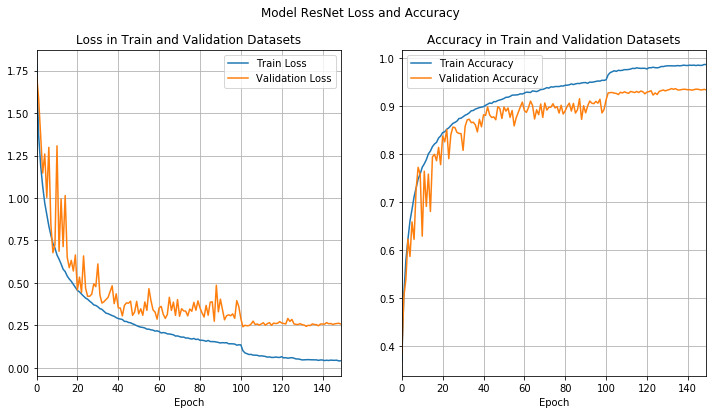

In [14]:
shortcut_on = True
dropout_on = False
dropout_rates = [0.3, 0.2]
opt = Adam(learning_rate=lr_schedule(0)) #RMSprop(lr=0.001)

cnn_model = ResNet(shortcut_on, dropout_on, dropout_rates)
# cnn_model.summary() # print NN structure
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

data_augmentation = True
batch_size = 128
epochs = 150
validation_data=(X_test, y_test)

# Prepare callbacks for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=20,
                               min_lr=0.5e-6,
                               verbose=1)

callbacks = [lr_scheduler]

if not data_augmentation:
    print('Not using data augmentation.')
    history = cnn_model.fit(X_train,y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=validation_data,
                            shuffle=True,
                            callbacks=callbacks)

else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        shear_range=0.2,  # set range for random shear
        zoom_range=0.2,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        fill_mode='nearest',  # set mode for filling points outside the input boundaries
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale=None,  # set rescaling factor (applied before any other transformation)
        preprocessing_function=None,  # set function that will be applied on each input
        data_format=None,  # image data format, either "channels_first" or "channels_last"
        validation_split=0.0  # fraction of images reserved for validation (strictly between 0 and 1)
    )

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history = cnn_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                      epochs=epochs,
                                      validation_data=validation_data,
                                      max_queue_size=10,
                                      workers=8,
                                      callbacks=callbacks,
                                      use_multiprocessing=True
                                     )

plot_learning_curve(modelHistory = history, model_name = 'ResNet')

# Model evaluation

Test Accuracy: 0.9333999752998352


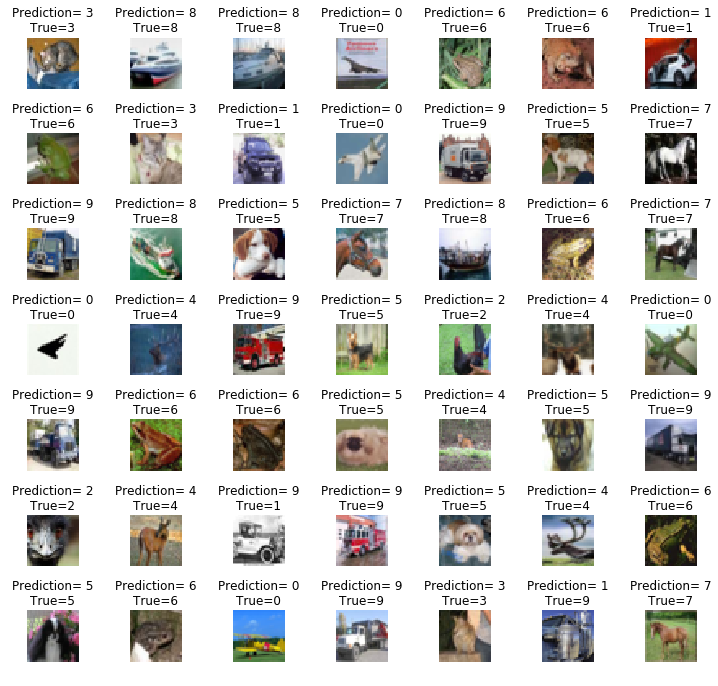

In [15]:
evaluation = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: {}'.format(evaluation[1]))
predicted_classes = cnn_model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

y_test_num = y_test.argmax(1)

L=7
W=7
fig,axes = plt.subplots(L,W,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction= {}\nTrue={}'.format(predicted_classes[i],y_test_num[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

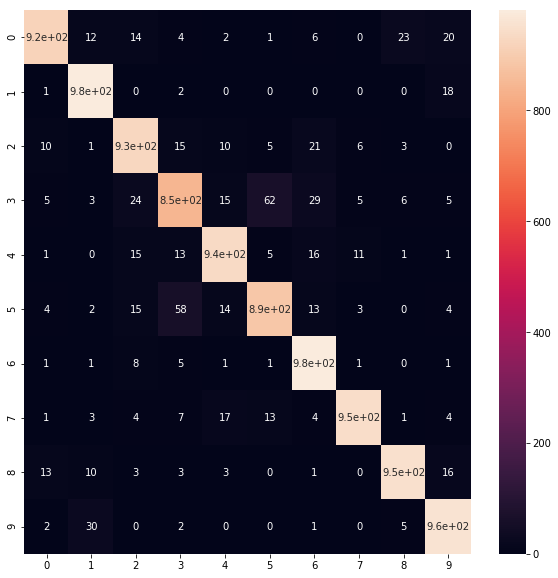

In [16]:
cm = confusion_matrix(y_test_num, predicted_classes)
cm
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True)
plt.ioff()

# Visualize feature maps

Input shape:  (50, 32, 32, 3)


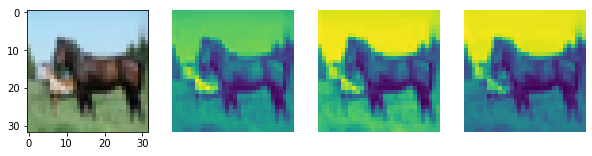

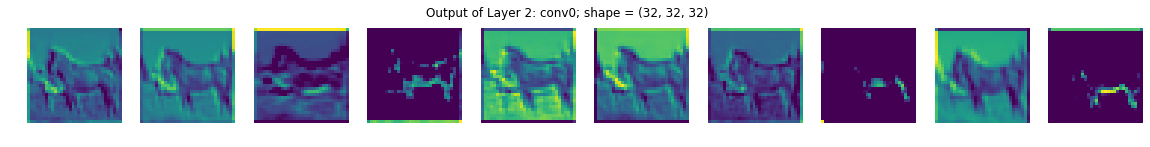

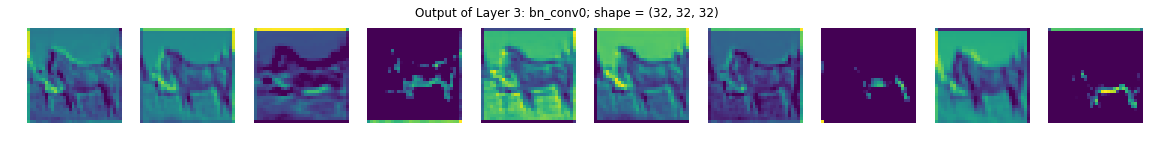

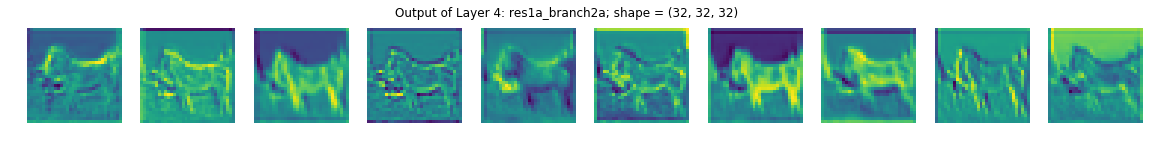

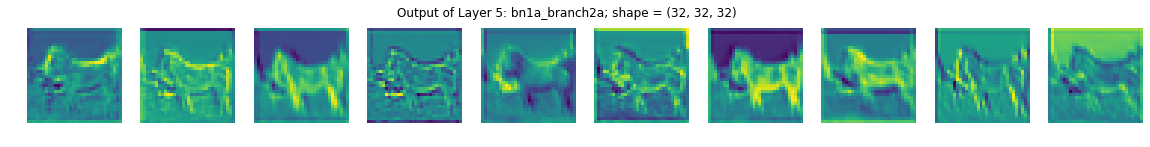

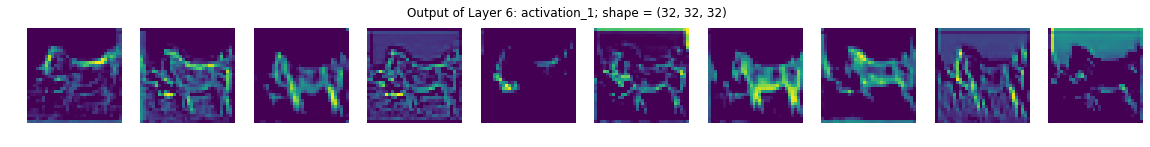

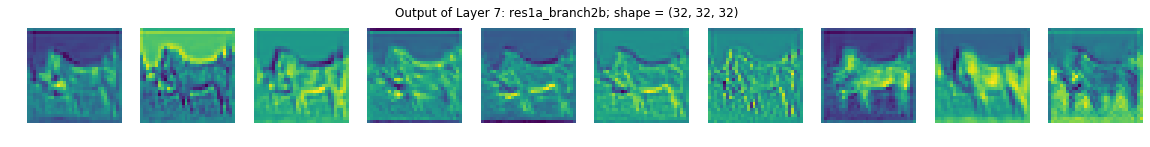

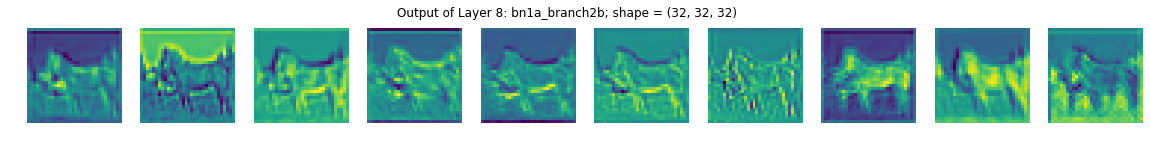

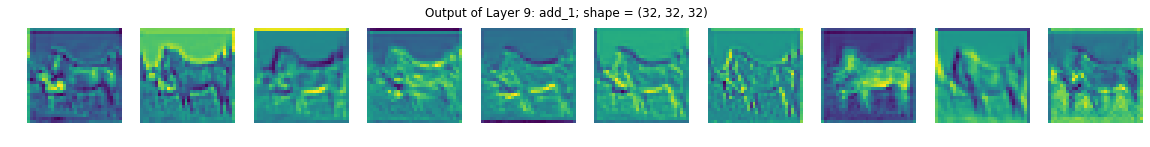

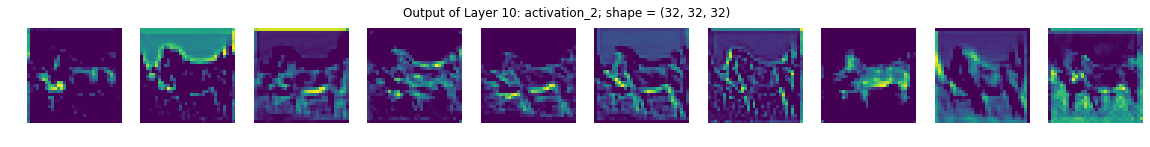

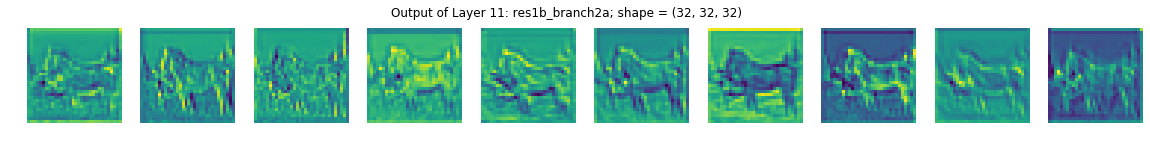

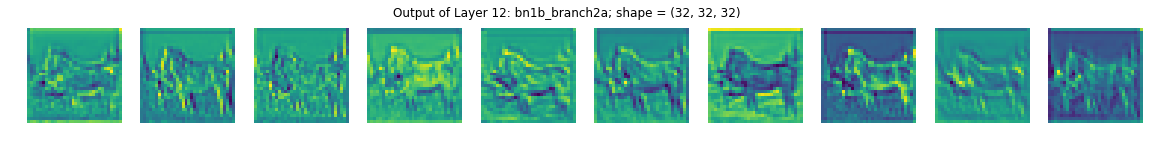

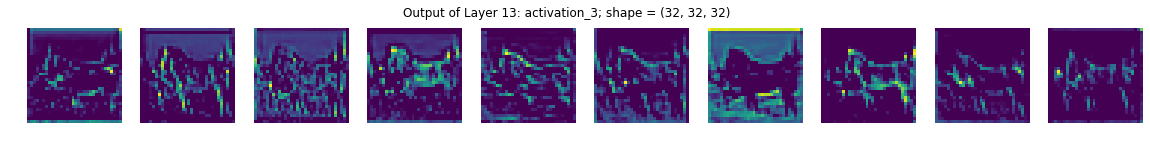

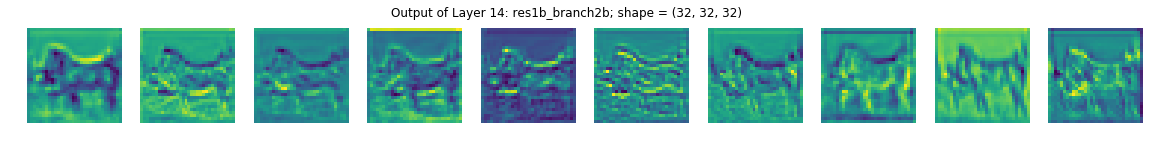

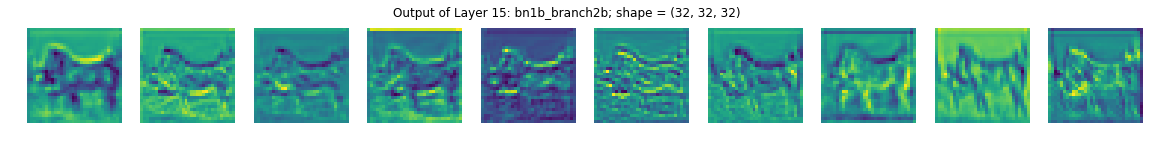

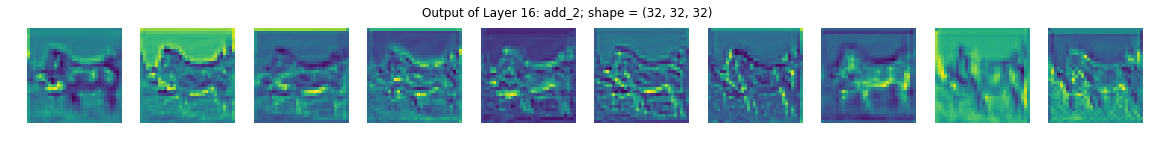

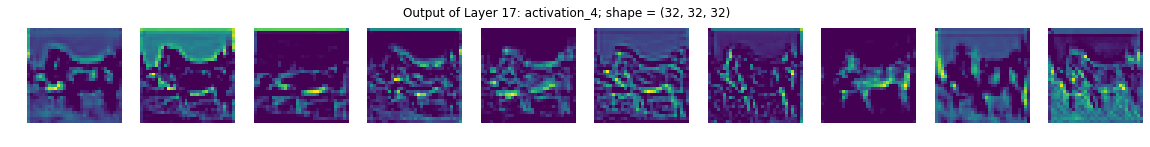

In [17]:
input_batch = 50
input_im = X_train[:input_batch, :, :, :]
input_show = 12
print('Input shape: ', input_im.shape)

# print input image:
plt.figure(figsize=(10, 3))
plt.subplot(1, 4, 1)
plt.imshow(X_train[input_show], interpolation='none')
for i in range(3):
    plt.subplot(1, 4, i+2)
    plt.imshow(X_train[input_show][:, :, i], cmap='viridis', interpolation='none')
    plt.axis('off')

# print feature maps
for layer_id in range(2, 18):
    intermediate_layer_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[layer_id].output)
    layer_output = intermediate_layer_model.predict(input_im)[input_show]
    plt.figure(figsize=(20, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(layer_output[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle('Output of Layer {}: '.format(layer_id) + cnn_model.layers[layer_id].name + '; shape = ' + str(layer_output.shape))

# Save model

In [ ]:
#import os 
#directory = os.path.join(os.getcwd(), 'saved_models')

#if not os.path.isdir(directory):
#    os.makedirs(directory)
#model_path = os.path.join(directory, 'keras_cifar10_trained_model.h5')
#cnn_model.save(model_path)